In [ ]:
!pip install ultralytics opencv-python

In [ ]:
import cv2
import os
import json

# Define paths
image_folder = "/kaggle/input/sortrd-chart-data/sorted_data/sorted_data/scatter/images"
json_folder = "/kaggle/input/sortrd-chart-data/sorted_data/sorted_data/scatter/annotations"
output_labels = "/kaggle/working/labels_02"

# Create labels folder
os.makedirs(output_labels, exist_ok=True)

# Process JSON files
for filename in os.listdir(json_folder):
    if filename.endswith(".json"):
        json_path = os.path.join(json_folder, filename)
        image_name = filename.replace(".json", ".jpg")
        image_path = os.path.join(image_folder, image_name)

        # Load JSON file
        with open(json_path, "r") as f:
            data = json.load(f)

        # Extract scatter points
        scatter_points = data["visual-elements"]["scatter points"][0]
        
        # Get image dimensions from "plot-bb"
        plot_bb = data["plot-bb"]
        #img_width, img_height = plot_bb["width"], plot_bb["height"]
        image = cv2.imread(image_path)
        img_height, img_width,_ = image.shape

        # Create YOLO label file
        yolo_label_path = os.path.join(output_labels, filename.replace(".json", ".txt"))
        with open(yolo_label_path, "w") as f:
            for point in scatter_points:
                x = (point["x"]) / img_width  # Normalize
                y = (point["y"]) / img_height
                w, h = 0.02, 0.02  # Small bounding box for scatter points
                f.write(f"0 {x} {y} {w} {h}\n")  # Class 0 for all points


In [ ]:
import os
import shutil
import glob

# Define paths
image_src = "/kaggle/input/sortrd-chart-data/sorted_data/sorted_data/scatter/images"
label_src = "/kaggle/working/labels_02"  # Labels already created earlier
dataset_path = "/kaggle/working/dataset_02"

# Create train and val directories
for split in ["train", "val"]:
    os.makedirs(os.path.join(dataset_path, split, "images"), exist_ok=True)
    os.makedirs(os.path.join(dataset_path, split, "labels"), exist_ok=True)

# Get list of images
image_files = sorted(glob.glob(os.path.join(image_src, "*.jpg")))
label_files = sorted(glob.glob(os.path.join(label_src, "*.txt")))

# Split into 80% train, 20% val
split_idx = int(len(image_files) * 0.8)
train_images, val_images = image_files[:split_idx], image_files[split_idx:]
train_labels, val_labels = label_files[:split_idx], label_files[split_idx:]

# Function to copy files
def copy_files(file_list, dest_folder):
    for file in file_list:
        filename = os.path.basename(file)
        shutil.copy(file, os.path.join(dest_folder, filename))

# Copy images and labels to train/val folders
copy_files(train_images, os.path.join(dataset_path, "train", "images"))
copy_files(val_images, os.path.join(dataset_path, "val", "images"))
copy_files(train_labels, os.path.join(dataset_path, "train", "labels"))
copy_files(val_labels, os.path.join(dataset_path, "val", "labels"))

print(f"Copied {len(train_images)} images to train and {len(val_images)} to val.")


In [ ]:
dataset_yaml = """
path: /kaggle/working/dataset_02
train: train
val: val
names:
  0: scatter_point
"""

with open("/kaggle/working/dataset_02.yaml", "w") as f:
    f.write(dataset_yaml)


In [ ]:
from ultralytics import YOLO

# Load YOLOv8 model
#model = YOLO("yolov8x.pt")

# Train YOLO
"""model.train(
    data="/kaggle/working/dataset2.yaml",
    epochs=50,
    imgsz=640,
    batch=16
)"""

#from ultralytics import YOLO



model = YOLO("/kaggle/input/scatter-dot-yolo-03/other/default/12/best_12_03_25_version_1_imgsize_1600.pt")

# Train with inline hyperparameter overrides
model.train(
    data="/kaggle/working/dataset_02.yaml",
    epochs=100,
    imgsz=2560,
    batch=1,
    lr0=1e-3,  
    optimizer="SGD",
    single_cls =  True,
    dropout	= 0.3,
    cos_lr=True,
    iou=0.7,
    weight_decay=0.0005,
    momentum=0.937,
    box=0.05,  # Box loss gain
    cls=0.02,  # Lower class loss weight (since only 1 class)
    dfl=0.2,  # Distribution focal loss gain
    mosaic=0.2, mixup=0.2,  # Data augmentation
    amp=True
)

In [ ]:
model = YOLO("/kaggle/working/runs/detect/train12/weights/best.pt")
model.tune(data="/kaggle/working/dataset.yaml", epochs=2)


In [ ]:
from ultralytics import YOLO

image_path = "/kaggle/input/sortrd-chart-data/sorted_data/sorted_data/scatter/images/001f896fb543.jpg"

# Load trained model
model = YOLO("/kaggle/working/runs/detect/train5/weights/best.pt")

results = model(image_path)

# Show results correctly
from PIL import Image
import matplotlib.pyplot as plt

# Open and display the image
image = Image.open(image_path)
plt.imshow(image)

# Access the first result and plot the detections
results[0].show()



image 1/1 /kaggle/input/benetech-making-graphs-accessible/test/images/00f5404753cf.jpg: 1888x2560 39 items, 305.7ms
Speed: 21.8ms preprocess, 305.7ms inference, 1.6ms postprocess per image at shape (1, 3, 1888, 2560)


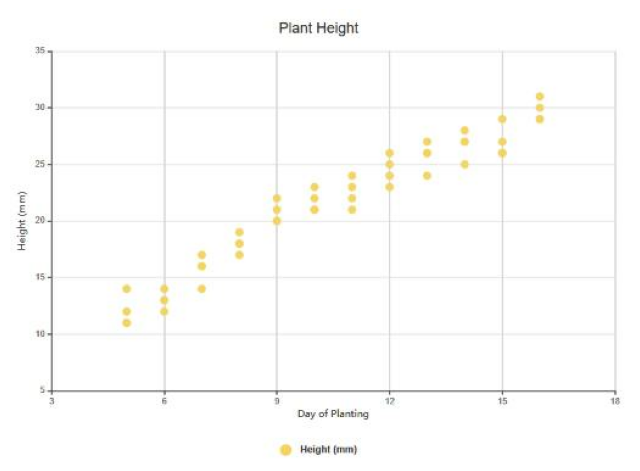

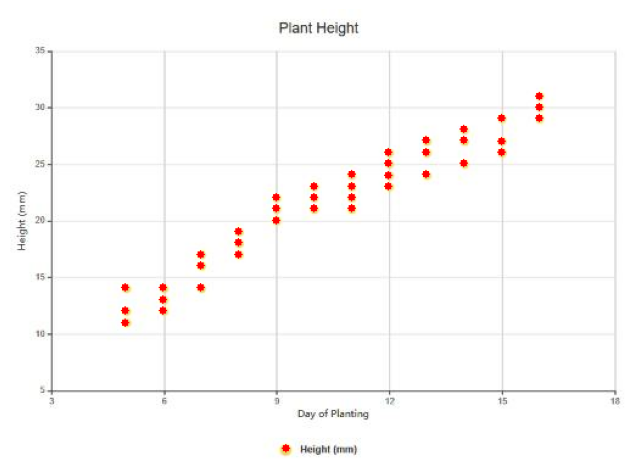

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from ultralytics import YOLO

# Load trained model
model = YOLO("/kaggle/working/runs/detect/train/weights/best.pt")

# Define image path
image_path = "/kaggle/input/benetech-making-graphs-accessible/test/images/00f5404753cf.jpg"

# Run inference
results = model(image_path)



# Load the image with OpenCV
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(8, 6))
plt.imshow(image)
plt.axis("off")
plt.show()

# Get first result from the list
result = results[0]

# Extract and plot middle points of detected scatter points
for box in result.boxes:
    x1, y1, x2, y2 = map(int, box.xyxy[0])  # Bounding box coordinates
    center_x = (x1 + x2) // 2  # Middle X
    center_y = (y1 + y2) // 2  # Middle Y
    cv2.circle(image, (center_x, center_y), 3, (255, 0, 0), -1)  # Draw center point

# Show image with scatter points
plt.figure(figsize=(8, 6))
plt.imshow(image)
plt.axis("off")
plt.show()



image 1/1 /kaggle/input/sortrd-chart-data/sorted_data/sorted_data/scatter/images/21adf3344f2b.jpg: 1504x2560 14 items, 247.6ms
Speed: 27.7ms preprocess, 247.6ms inference, 131.3ms postprocess per image at shape (1, 3, 1504, 2560)


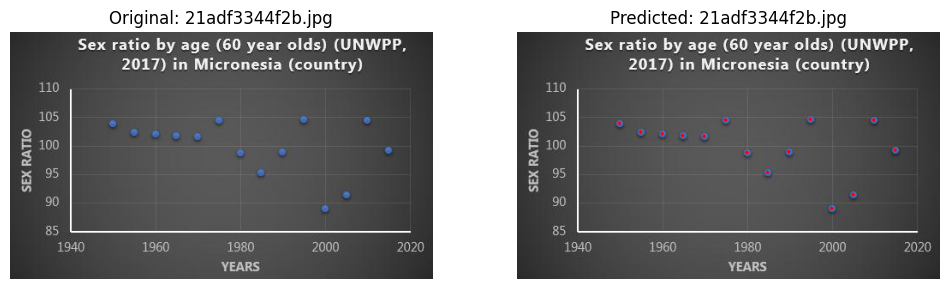


image 1/1 /kaggle/input/sortrd-chart-data/sorted_data/sorted_data/scatter/images/8d4aa40a3af0.jpg: 1504x2560 19 items, 242.4ms
Speed: 20.5ms preprocess, 242.4ms inference, 1.6ms postprocess per image at shape (1, 3, 1504, 2560)


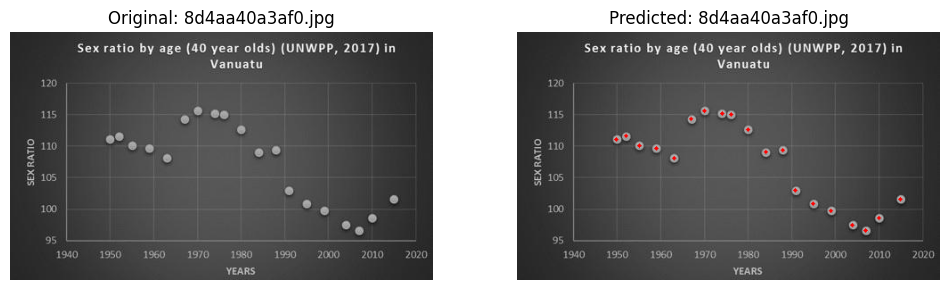


image 1/1 /kaggle/input/sortrd-chart-data/sorted_data/sorted_data/scatter/images/9446f4aa05d8.jpg: 1536x2560 22 items, 250.4ms
Speed: 20.6ms preprocess, 250.4ms inference, 1.3ms postprocess per image at shape (1, 3, 1536, 2560)


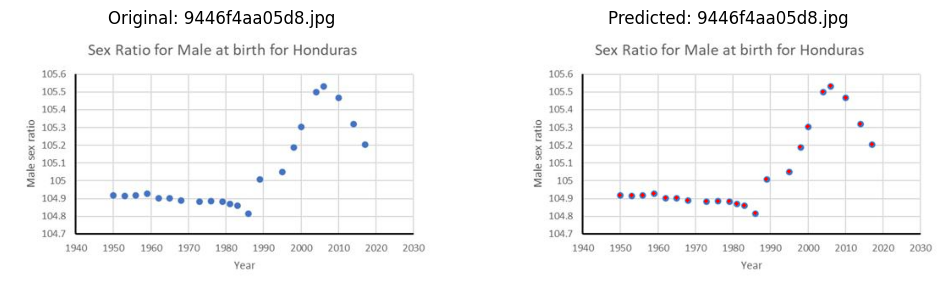


image 1/1 /kaggle/input/sortrd-chart-data/sorted_data/sorted_data/scatter/images/452ec169b243.jpg: 1536x2560 12 items, 246.6ms
Speed: 25.1ms preprocess, 246.6ms inference, 1.7ms postprocess per image at shape (1, 3, 1536, 2560)


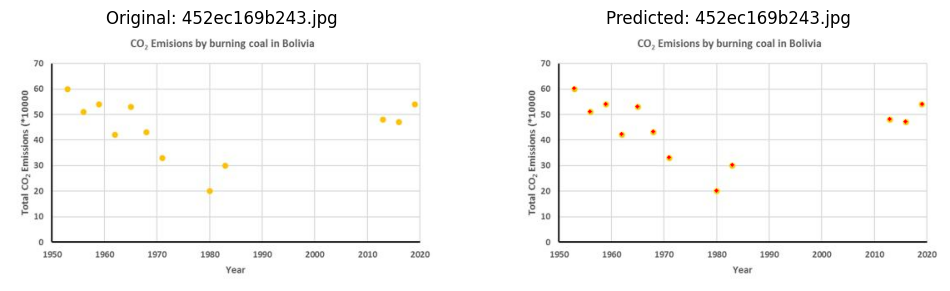


image 1/1 /kaggle/input/sortrd-chart-data/sorted_data/sorted_data/scatter/images/8acebb5fcd06.jpg: 1440x2560 20 items, 238.7ms
Speed: 24.9ms preprocess, 238.7ms inference, 1.3ms postprocess per image at shape (1, 3, 1440, 2560)


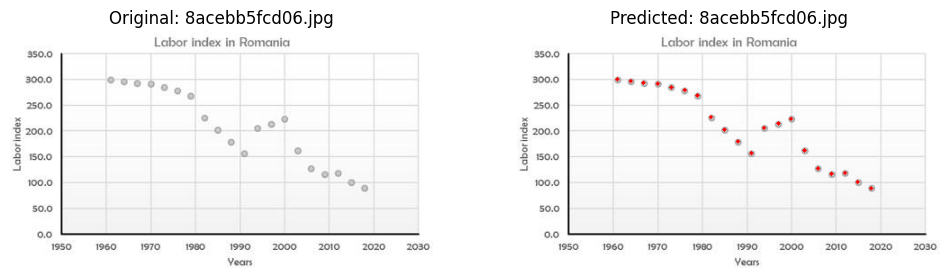


image 1/1 /kaggle/input/sortrd-chart-data/sorted_data/sorted_data/scatter/images/fdad2e52ebb0.jpg: 1664x2560 26 items, 266.5ms
Speed: 27.8ms preprocess, 266.5ms inference, 1.3ms postprocess per image at shape (1, 3, 1664, 2560)


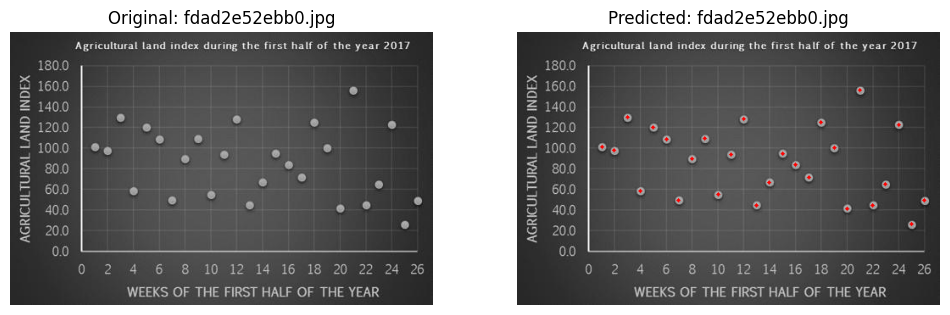


image 1/1 /kaggle/input/sortrd-chart-data/sorted_data/sorted_data/scatter/images/5dcbec3ae569.jpg: 1472x2560 24 items, 244.0ms
Speed: 25.5ms preprocess, 244.0ms inference, 1.4ms postprocess per image at shape (1, 3, 1472, 2560)


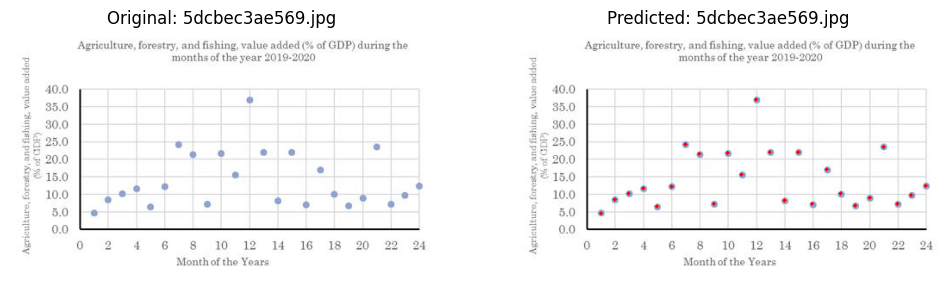


image 1/1 /kaggle/input/sortrd-chart-data/sorted_data/sorted_data/scatter/images/19a648e07881.jpg: 1504x2560 15 items, 243.6ms
Speed: 24.6ms preprocess, 243.6ms inference, 1.4ms postprocess per image at shape (1, 3, 1504, 2560)


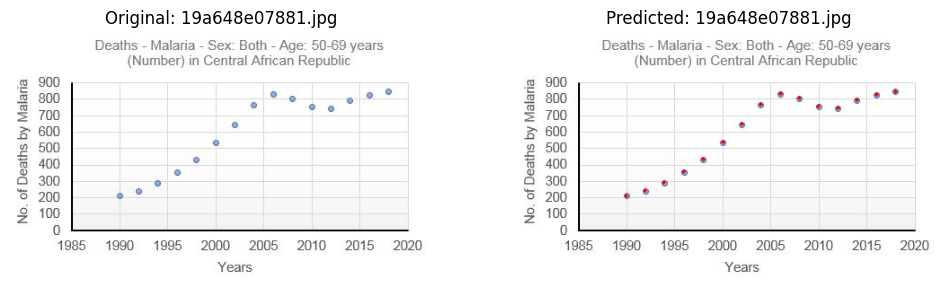


image 1/1 /kaggle/input/sortrd-chart-data/sorted_data/sorted_data/scatter/images/1de1e506189c.jpg: 1568x2560 26 items, 258.9ms
Speed: 26.5ms preprocess, 258.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1568, 2560)


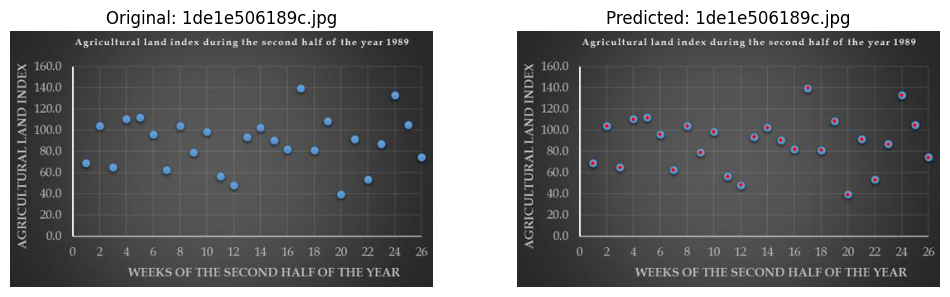


image 1/1 /kaggle/input/sortrd-chart-data/sorted_data/sorted_data/scatter/images/e690cebf7033.jpg: 1600x2560 24 items, 263.5ms
Speed: 25.8ms preprocess, 263.5ms inference, 1.4ms postprocess per image at shape (1, 3, 1600, 2560)


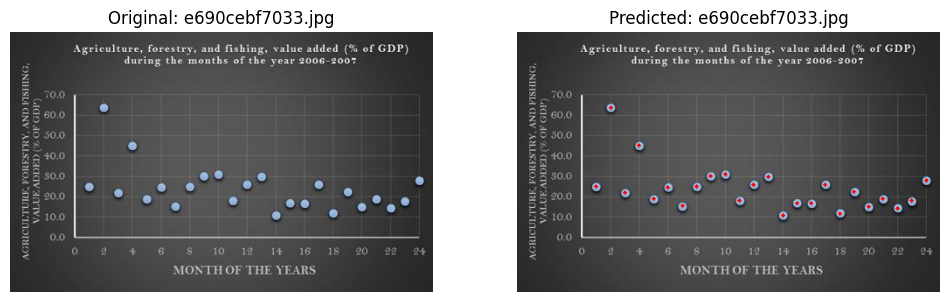


image 1/1 /kaggle/input/sortrd-chart-data/sorted_data/sorted_data/scatter/images/718363846875.jpg: 1504x2560 10 items, 243.8ms
Speed: 28.4ms preprocess, 243.8ms inference, 1.4ms postprocess per image at shape (1, 3, 1504, 2560)


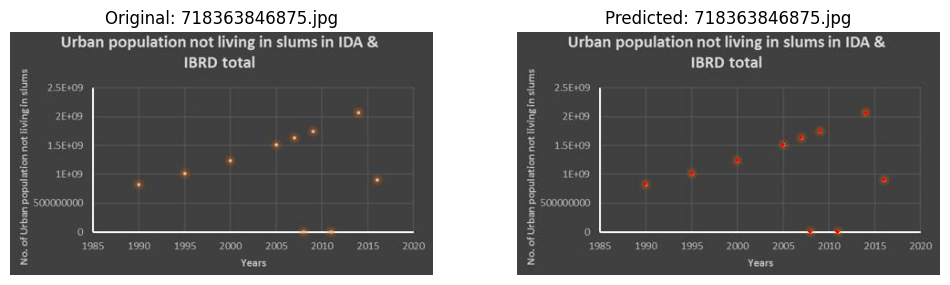


image 1/1 /kaggle/input/sortrd-chart-data/sorted_data/sorted_data/scatter/images/24af28c007ac.jpg: 2112x2560 50 items, 341.9ms
Speed: 33.2ms preprocess, 341.9ms inference, 1.5ms postprocess per image at shape (1, 3, 2112, 2560)


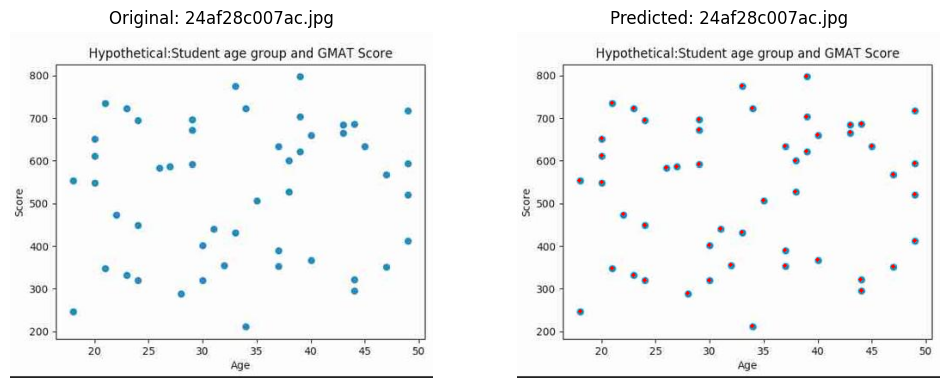


image 1/1 /kaggle/input/sortrd-chart-data/sorted_data/sorted_data/scatter/images/6e660fedb8ea.jpg: 1536x2560 17 items, 249.6ms
Speed: 22.6ms preprocess, 249.6ms inference, 1.4ms postprocess per image at shape (1, 3, 1536, 2560)


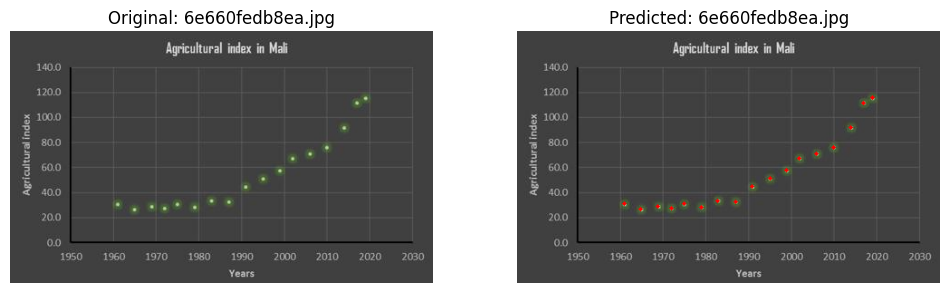


image 1/1 /kaggle/input/sortrd-chart-data/sorted_data/sorted_data/scatter/images/04fc7eca8223.jpg: 1568x2560 17 items, 256.3ms
Speed: 27.3ms preprocess, 256.3ms inference, 1.5ms postprocess per image at shape (1, 3, 1568, 2560)


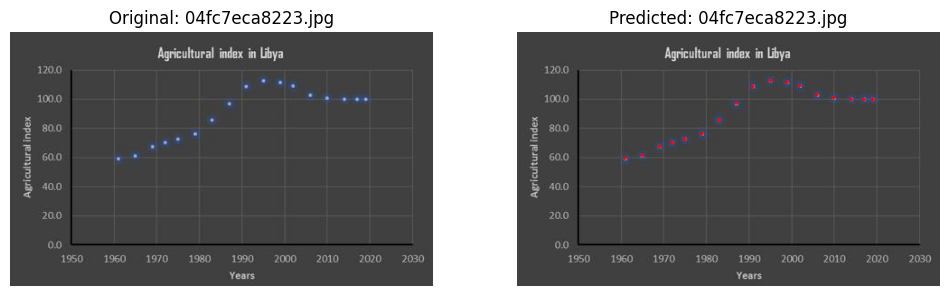


image 1/1 /kaggle/input/sortrd-chart-data/sorted_data/sorted_data/scatter/images/6b30d9db9da0.jpg: 1696x2560 25 items, 277.4ms
Speed: 27.9ms preprocess, 277.4ms inference, 1.4ms postprocess per image at shape (1, 3, 1696, 2560)


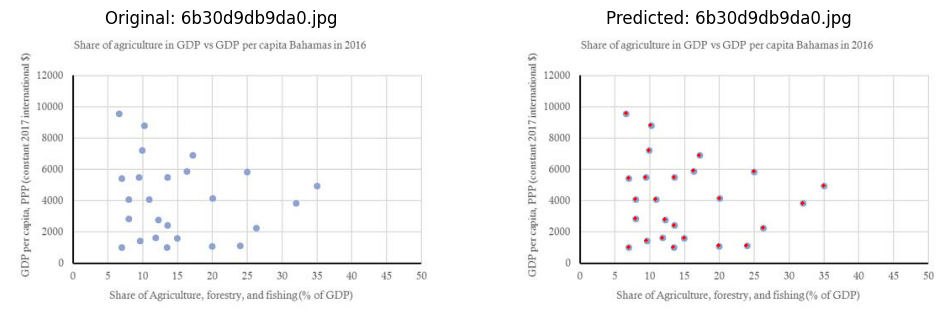


image 1/1 /kaggle/input/sortrd-chart-data/sorted_data/sorted_data/scatter/images/96c717f9be7e.jpg: 1536x2560 24 items, 244.9ms
Speed: 25.3ms preprocess, 244.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1536, 2560)


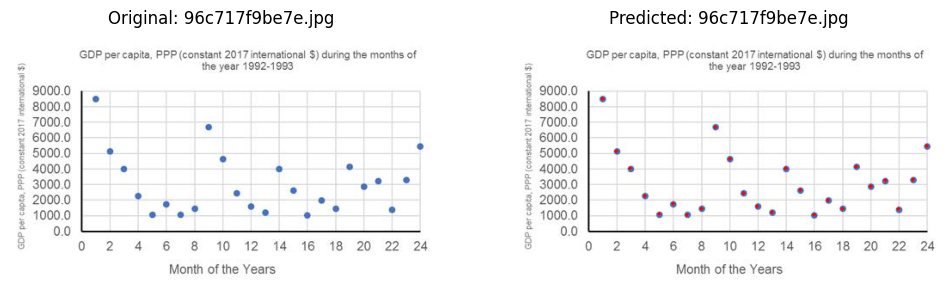


image 1/1 /kaggle/input/sortrd-chart-data/sorted_data/sorted_data/scatter/images/73043203bb58.jpg: 1728x2560 25 items, 279.7ms
Speed: 28.1ms preprocess, 279.7ms inference, 1.3ms postprocess per image at shape (1, 3, 1728, 2560)


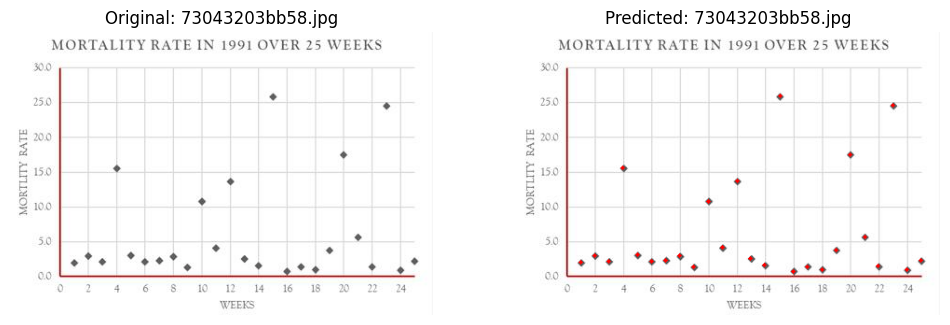


image 1/1 /kaggle/input/sortrd-chart-data/sorted_data/sorted_data/scatter/images/1e2eb1067604.jpg: 1728x2560 25 items, 278.5ms
Speed: 27.7ms preprocess, 278.5ms inference, 1.7ms postprocess per image at shape (1, 3, 1728, 2560)


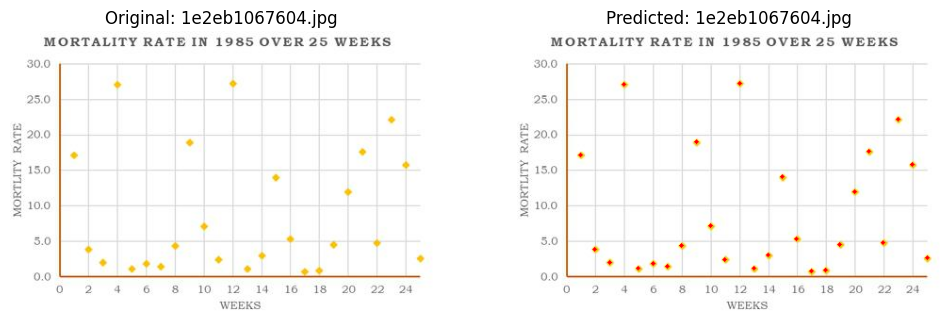


image 1/1 /kaggle/input/sortrd-chart-data/sorted_data/sorted_data/scatter/images/71b2d5e0182c.jpg: 1504x2560 30 items, 245.6ms
Speed: 24.6ms preprocess, 245.6ms inference, 1.7ms postprocess per image at shape (1, 3, 1504, 2560)


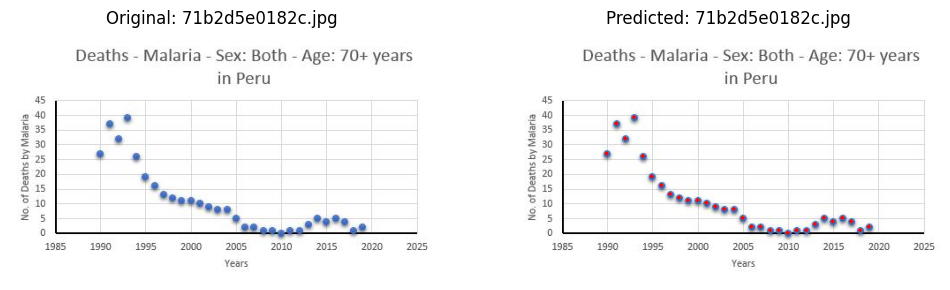


image 1/1 /kaggle/input/sortrd-chart-data/sorted_data/sorted_data/scatter/images/c68f3ee84f5f.jpg: 1472x2560 54 items, 240.3ms
Speed: 24.8ms preprocess, 240.3ms inference, 1.4ms postprocess per image at shape (1, 3, 1472, 2560)


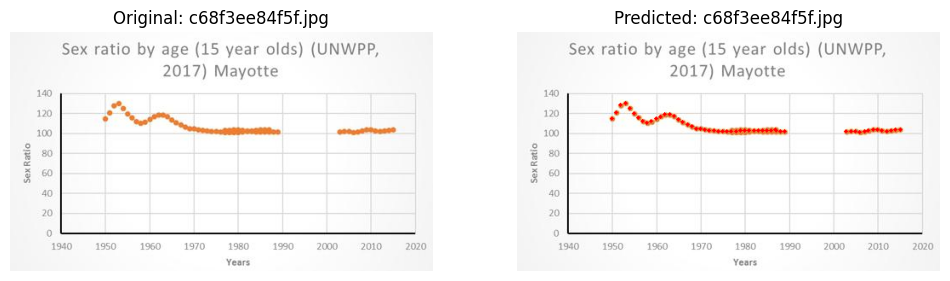


image 1/1 /kaggle/input/sortrd-chart-data/sorted_data/sorted_data/scatter/images/9f45b5fa180f.jpg: 1568x2560 71 items, 256.8ms
Speed: 26.1ms preprocess, 256.8ms inference, 1.4ms postprocess per image at shape (1, 3, 1568, 2560)


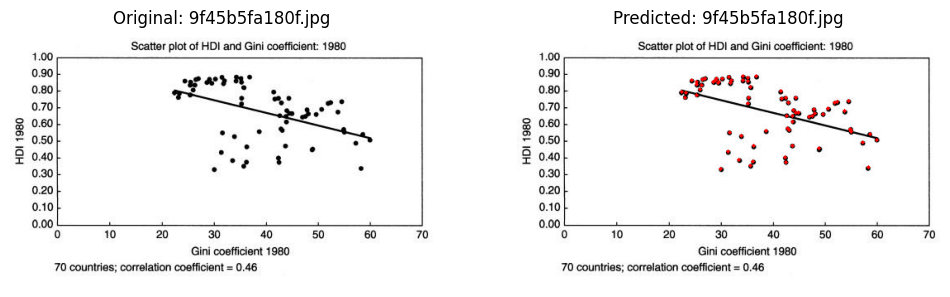


image 1/1 /kaggle/input/sortrd-chart-data/sorted_data/sorted_data/scatter/images/35921ccabc86.jpg: 1568x2560 7 items, 255.3ms
Speed: 25.9ms preprocess, 255.3ms inference, 1.7ms postprocess per image at shape (1, 3, 1568, 2560)


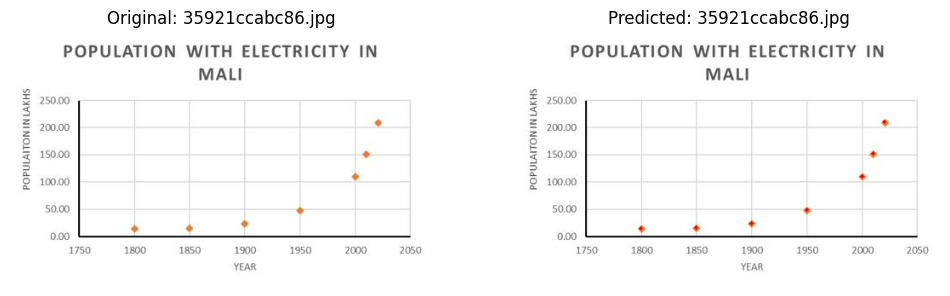


image 1/1 /kaggle/input/sortrd-chart-data/sorted_data/sorted_data/scatter/images/cb3d1d9c8b17.jpg: 1536x2560 24 items, 247.4ms
Speed: 25.3ms preprocess, 247.4ms inference, 1.3ms postprocess per image at shape (1, 3, 1536, 2560)


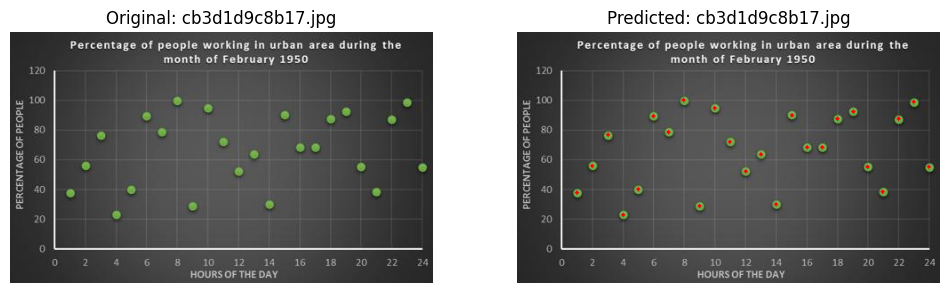


image 1/1 /kaggle/input/sortrd-chart-data/sorted_data/sorted_data/scatter/images/67d62a75cc15.jpg: 1536x2560 22 items, 248.9ms
Speed: 25.2ms preprocess, 248.9ms inference, 1.7ms postprocess per image at shape (1, 3, 1536, 2560)


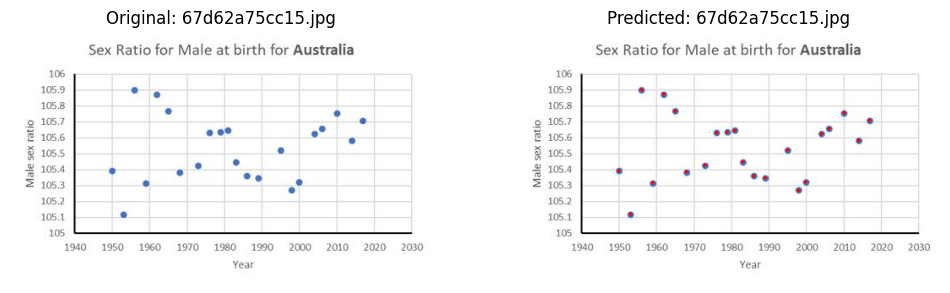


image 1/1 /kaggle/input/sortrd-chart-data/sorted_data/sorted_data/scatter/images/51853903bd66.jpg: 1728x2560 25 items, 281.0ms
Speed: 28.3ms preprocess, 281.0ms inference, 1.3ms postprocess per image at shape (1, 3, 1728, 2560)


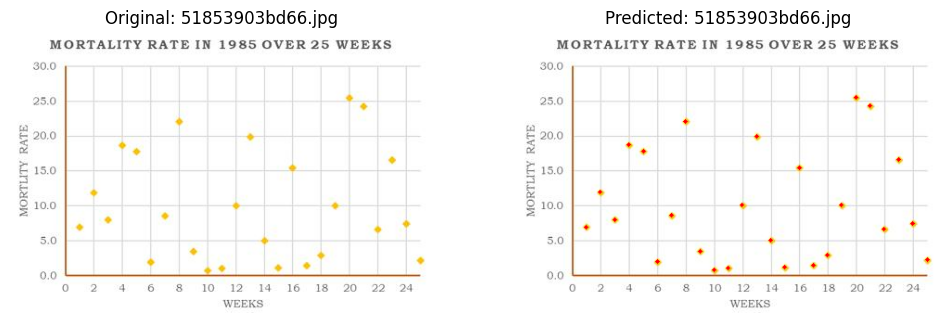


image 1/1 /kaggle/input/sortrd-chart-data/sorted_data/sorted_data/scatter/images/c21b269ea38c.jpg: 1568x2560 11 items, 256.8ms
Speed: 26.3ms preprocess, 256.8ms inference, 1.3ms postprocess per image at shape (1, 3, 1568, 2560)


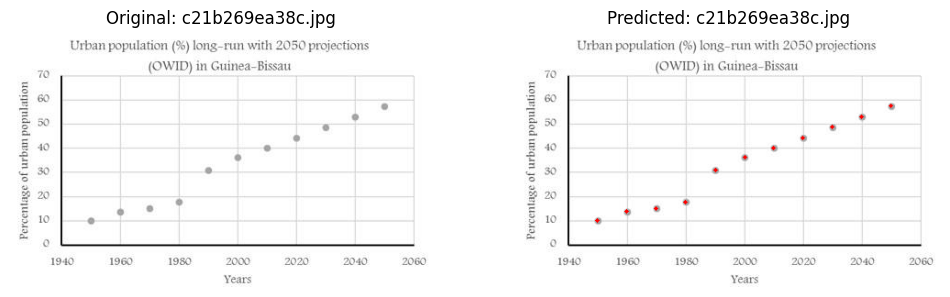


image 1/1 /kaggle/input/sortrd-chart-data/sorted_data/sorted_data/scatter/images/b46a98fbb9fd.jpg: 1792x2560 25 items, 290.4ms
Speed: 29.0ms preprocess, 290.4ms inference, 1.4ms postprocess per image at shape (1, 3, 1792, 2560)


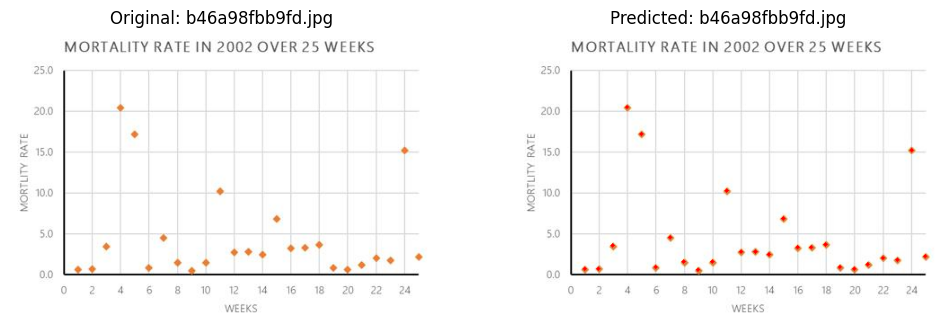


image 1/1 /kaggle/input/sortrd-chart-data/sorted_data/sorted_data/scatter/images/077fcbd76989.jpg: 1504x2560 16 items, 245.1ms
Speed: 20.6ms preprocess, 245.1ms inference, 1.3ms postprocess per image at shape (1, 3, 1504, 2560)


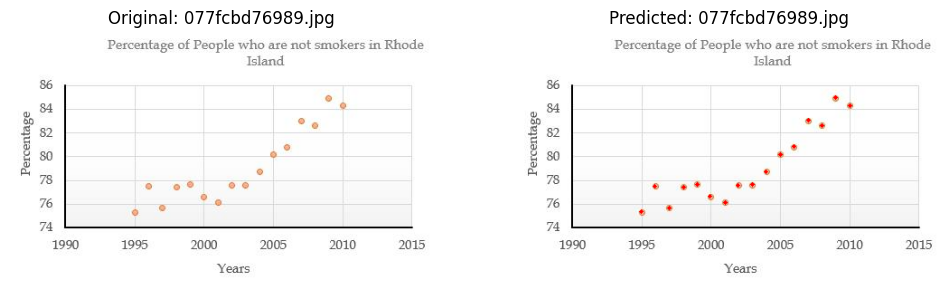


image 1/1 /kaggle/input/sortrd-chart-data/sorted_data/sorted_data/scatter/images/7b43c7013ec9.jpg: 1504x2560 20 items, 245.0ms
Speed: 19.5ms preprocess, 245.0ms inference, 1.6ms postprocess per image at shape (1, 3, 1504, 2560)


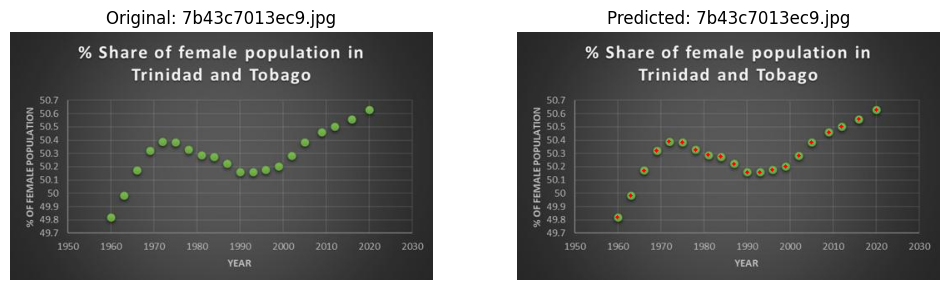


image 1/1 /kaggle/input/sortrd-chart-data/sorted_data/sorted_data/scatter/images/cf279bcaa1ca.jpg: 1696x2560 26 items, 274.6ms
Speed: 27.7ms preprocess, 274.6ms inference, 1.3ms postprocess per image at shape (1, 3, 1696, 2560)


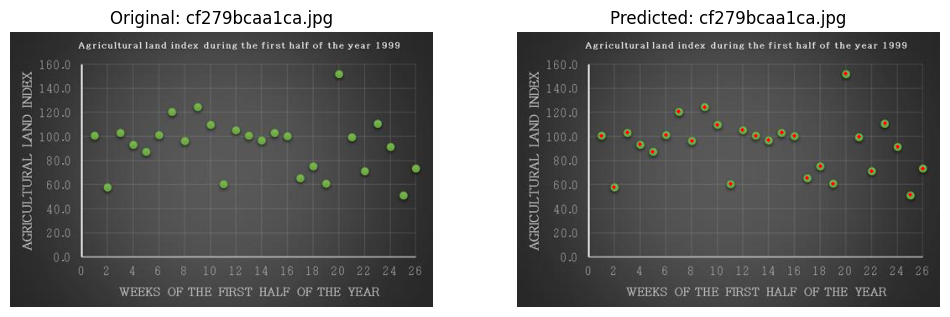


image 1/1 /kaggle/input/sortrd-chart-data/sorted_data/sorted_data/scatter/images/b62f4a6dbf31.jpg: 1536x2560 15 items, 246.0ms
Speed: 25.5ms preprocess, 246.0ms inference, 1.9ms postprocess per image at shape (1, 3, 1536, 2560)


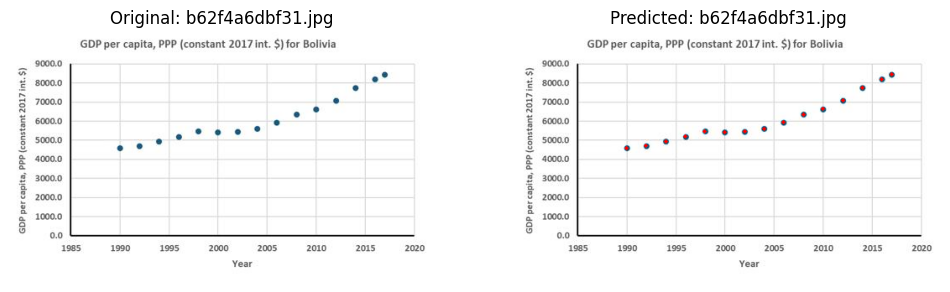


image 1/1 /kaggle/input/sortrd-chart-data/sorted_data/sorted_data/scatter/images/c72bc7d6cb18.jpg: 1664x2560 15 items, 266.0ms
Speed: 27.6ms preprocess, 266.0ms inference, 1.4ms postprocess per image at shape (1, 3, 1664, 2560)


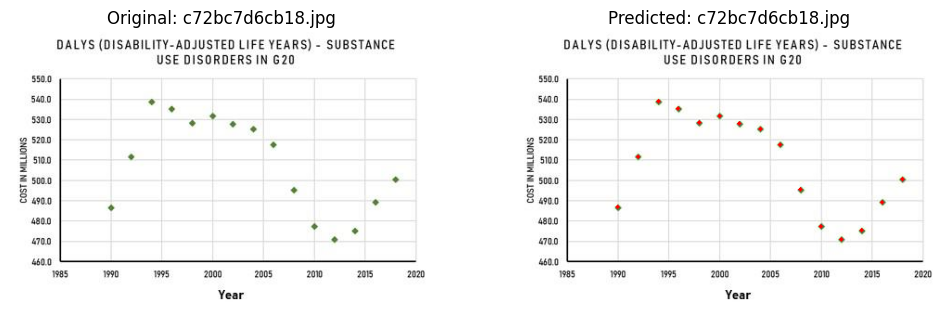


image 1/1 /kaggle/input/sortrd-chart-data/sorted_data/sorted_data/scatter/images/d4f11a2b3c2a.jpg: 1536x2560 30 items, 250.7ms
Speed: 25.7ms preprocess, 250.7ms inference, 1.4ms postprocess per image at shape (1, 3, 1536, 2560)


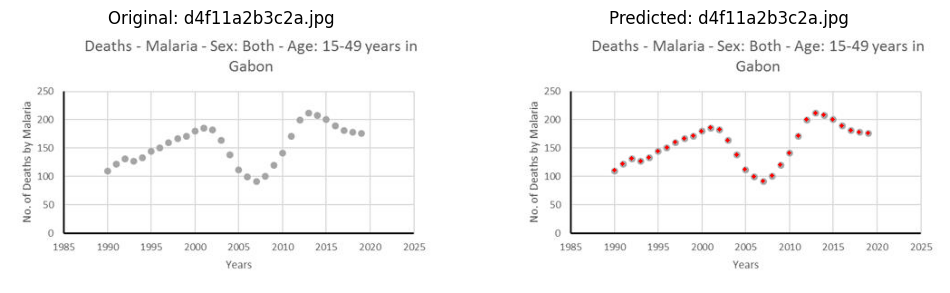


image 1/1 /kaggle/input/sortrd-chart-data/sorted_data/sorted_data/scatter/images/296bb093bf5c.jpg: 1568x2560 11 items, 257.7ms
Speed: 27.1ms preprocess, 257.7ms inference, 1.4ms postprocess per image at shape (1, 3, 1568, 2560)


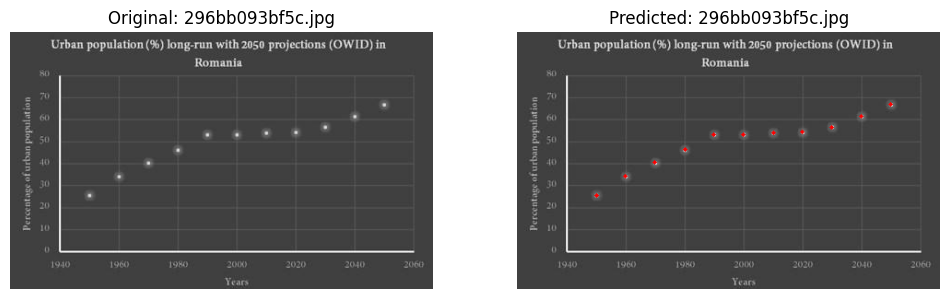


image 1/1 /kaggle/input/sortrd-chart-data/sorted_data/sorted_data/scatter/images/502715c5ea3a.jpg: 1760x2560 25 items, 288.1ms
Speed: 30.1ms preprocess, 288.1ms inference, 1.4ms postprocess per image at shape (1, 3, 1760, 2560)


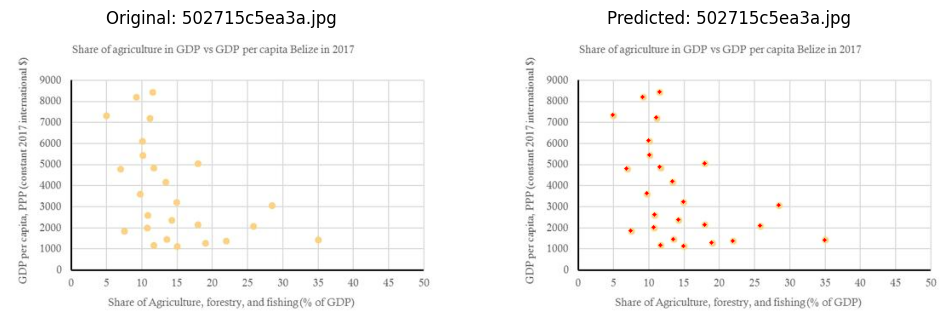


image 1/1 /kaggle/input/sortrd-chart-data/sorted_data/sorted_data/scatter/images/e71487368e0f.jpg: 1568x2560 24 items, 257.4ms
Speed: 26.4ms preprocess, 257.4ms inference, 1.3ms postprocess per image at shape (1, 3, 1568, 2560)


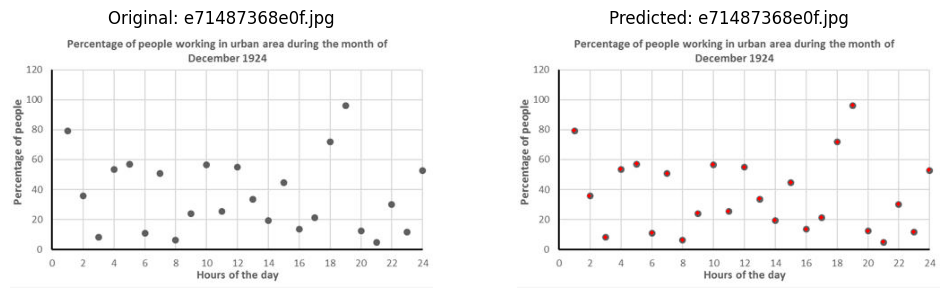


image 1/1 /kaggle/input/sortrd-chart-data/sorted_data/sorted_data/scatter/images/cca84b0aa0a0.jpg: 1600x2560 25 items, 259.8ms
Speed: 25.9ms preprocess, 259.8ms inference, 1.3ms postprocess per image at shape (1, 3, 1600, 2560)


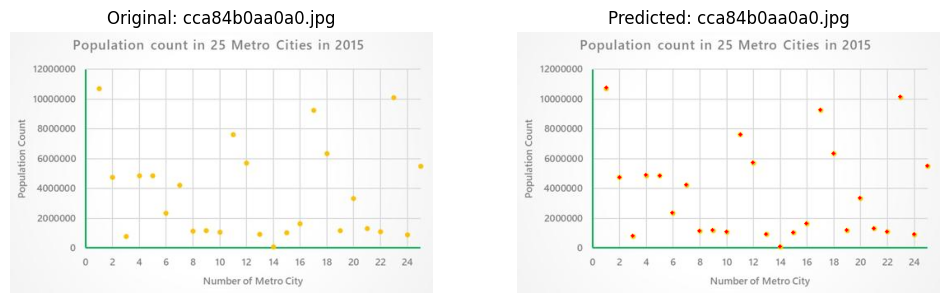


image 1/1 /kaggle/input/sortrd-chart-data/sorted_data/sorted_data/scatter/images/de3e51f1573f.jpg: 1472x2560 30 items, 242.4ms
Speed: 24.8ms preprocess, 242.4ms inference, 1.3ms postprocess per image at shape (1, 3, 1472, 2560)


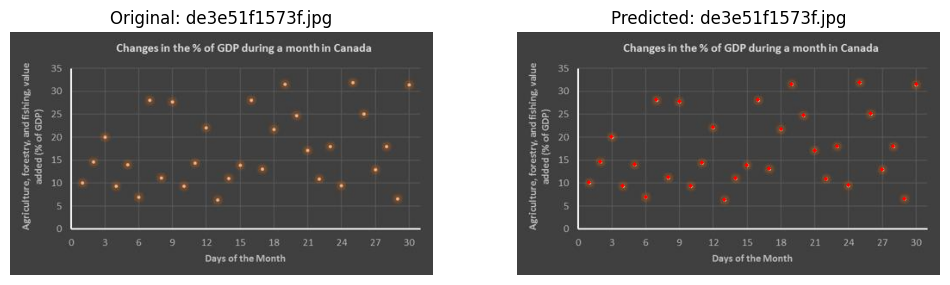


image 1/1 /kaggle/input/sortrd-chart-data/sorted_data/sorted_data/scatter/images/1636175c232b.jpg: 1536x2560 26 items, 250.0ms
Speed: 25.3ms preprocess, 250.0ms inference, 1.5ms postprocess per image at shape (1, 3, 1536, 2560)


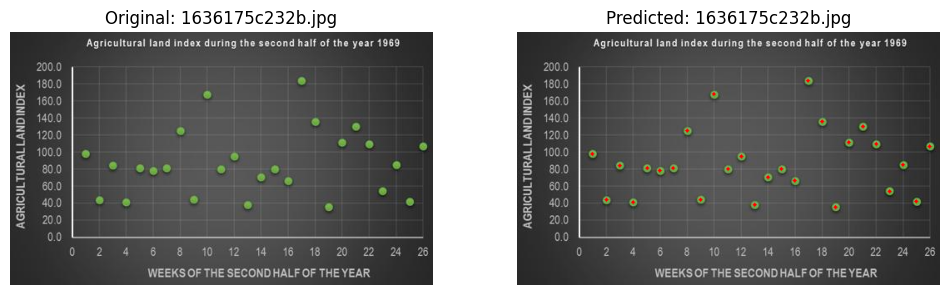


image 1/1 /kaggle/input/sortrd-chart-data/sorted_data/sorted_data/scatter/images/c43f56bb40a9.jpg: 1408x2560 14 items, 230.1ms
Speed: 22.3ms preprocess, 230.1ms inference, 1.4ms postprocess per image at shape (1, 3, 1408, 2560)


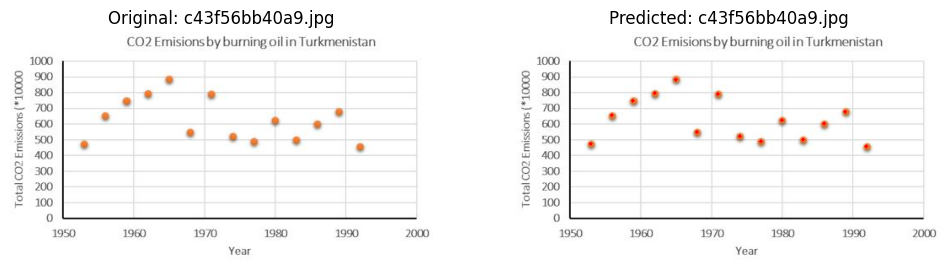


image 1/1 /kaggle/input/sortrd-chart-data/sorted_data/sorted_data/scatter/images/59d479cef6e0.jpg: 1568x2560 26 items, 256.1ms
Speed: 21.9ms preprocess, 256.1ms inference, 1.5ms postprocess per image at shape (1, 3, 1568, 2560)


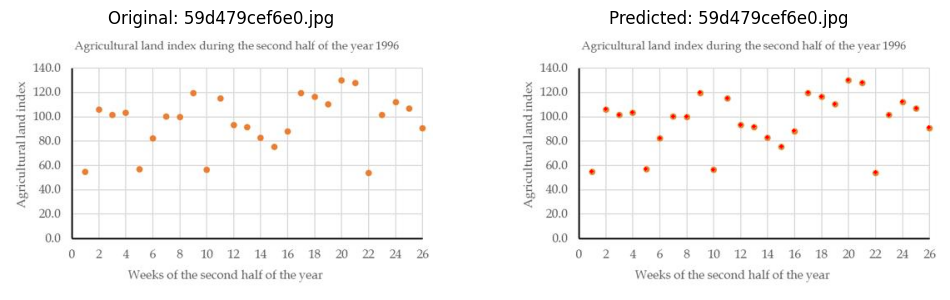


image 1/1 /kaggle/input/sortrd-chart-data/sorted_data/sorted_data/scatter/images/725de9ca799d.jpg: 1536x2560 17 items, 247.8ms
Speed: 21.5ms preprocess, 247.8ms inference, 1.4ms postprocess per image at shape (1, 3, 1536, 2560)


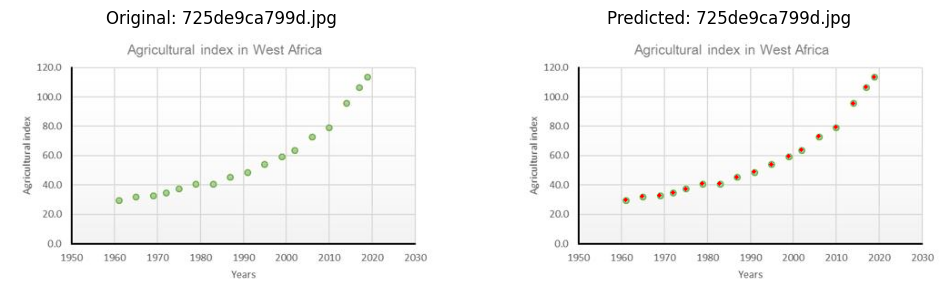


image 1/1 /kaggle/input/sortrd-chart-data/sorted_data/sorted_data/scatter/images/ea254bd70f47.jpg: 1472x2560 14 items, 240.3ms
Speed: 19.4ms preprocess, 240.3ms inference, 1.3ms postprocess per image at shape (1, 3, 1472, 2560)


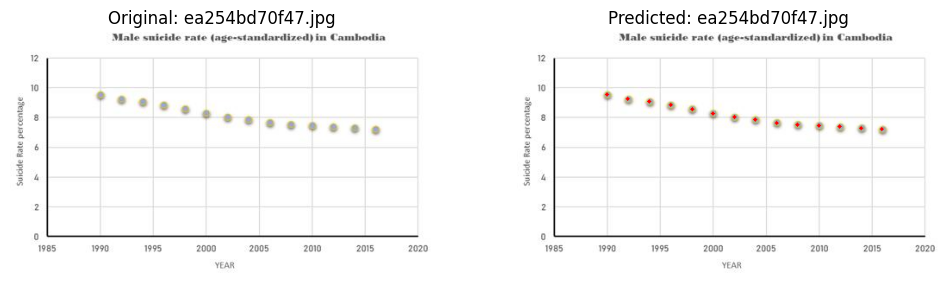


image 1/1 /kaggle/input/sortrd-chart-data/sorted_data/sorted_data/scatter/images/e75d6cd812fb.jpg: 1568x2560 11 items, 255.9ms
Speed: 26.6ms preprocess, 255.9ms inference, 1.4ms postprocess per image at shape (1, 3, 1568, 2560)


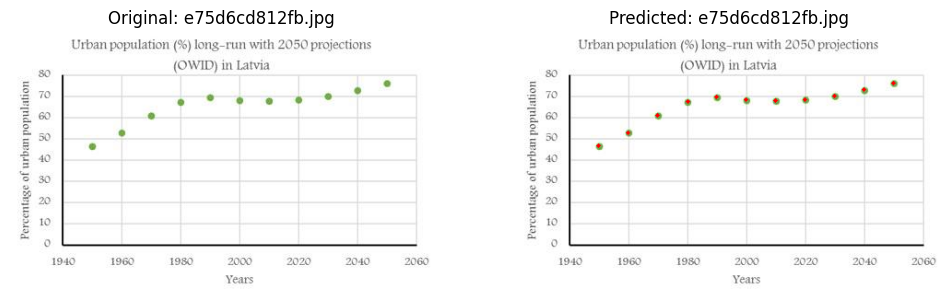


image 1/1 /kaggle/input/sortrd-chart-data/sorted_data/sorted_data/scatter/images/db88b42bce10.jpg: 1504x2560 14 items, 246.1ms
Speed: 27.0ms preprocess, 246.1ms inference, 1.4ms postprocess per image at shape (1, 3, 1504, 2560)


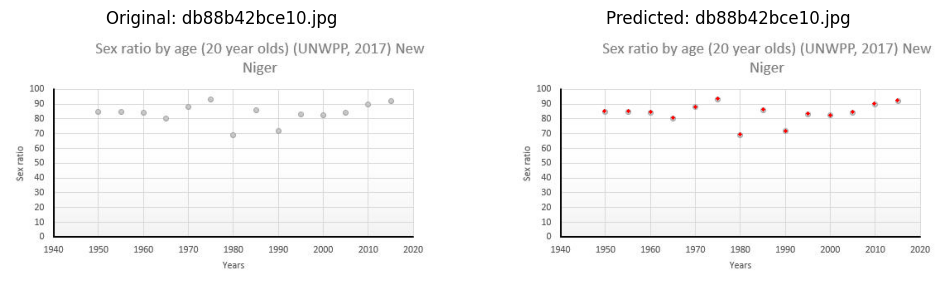


image 1/1 /kaggle/input/sortrd-chart-data/sorted_data/sorted_data/scatter/images/68e7eb737c76.jpg: 1536x2560 30 items, 246.0ms
Speed: 25.4ms preprocess, 246.0ms inference, 1.3ms postprocess per image at shape (1, 3, 1536, 2560)


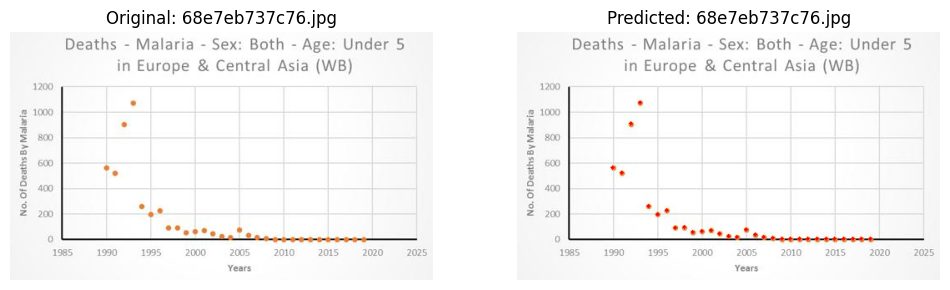


image 1/1 /kaggle/input/sortrd-chart-data/sorted_data/sorted_data/scatter/images/03ec6db5ecdb.jpg: 1536x2560 11 items, 244.8ms
Speed: 25.4ms preprocess, 244.8ms inference, 1.5ms postprocess per image at shape (1, 3, 1536, 2560)


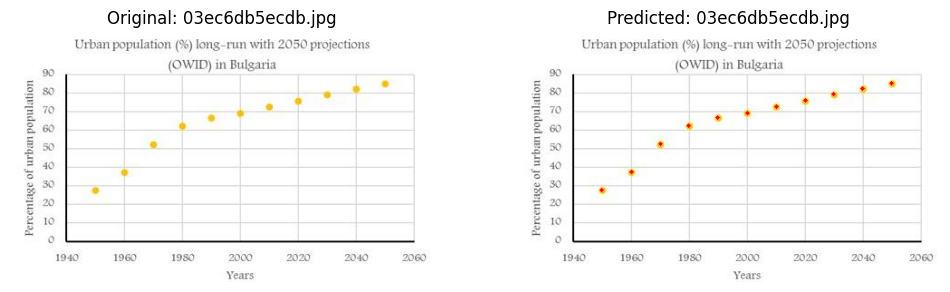


image 1/1 /kaggle/input/sortrd-chart-data/sorted_data/sorted_data/scatter/images/aa3cb6b0c184.jpg: 1632x2560 28 items, 267.0ms
Speed: 27.4ms preprocess, 267.0ms inference, 1.4ms postprocess per image at shape (1, 3, 1632, 2560)


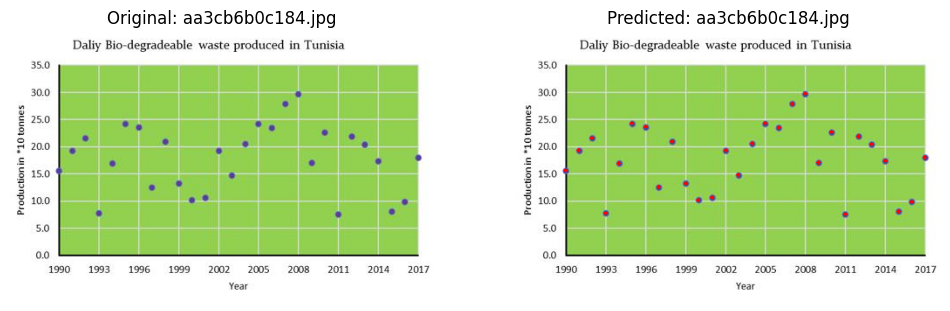


image 1/1 /kaggle/input/sortrd-chart-data/sorted_data/sorted_data/scatter/images/938877197e38.jpg: 1536x2560 14 items, 249.4ms
Speed: 25.2ms preprocess, 249.4ms inference, 1.4ms postprocess per image at shape (1, 3, 1536, 2560)


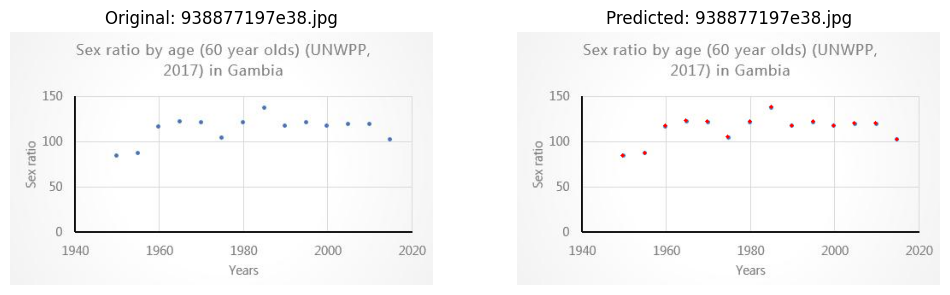


image 1/1 /kaggle/input/sortrd-chart-data/sorted_data/sorted_data/scatter/images/1a02427929a3.jpg: 1568x2560 26 items, 257.2ms
Speed: 26.4ms preprocess, 257.2ms inference, 1.4ms postprocess per image at shape (1, 3, 1568, 2560)


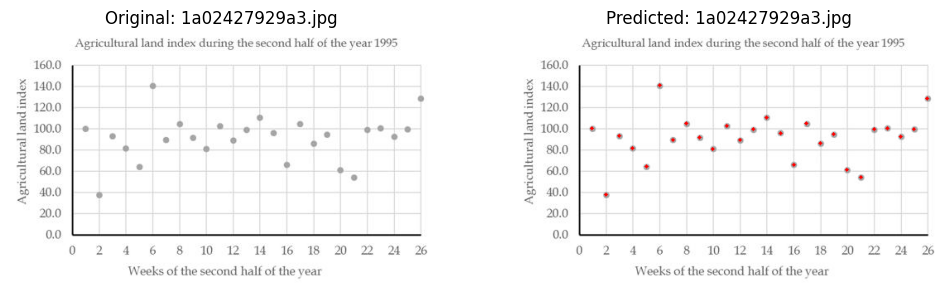

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO
import os
from PIL import Image

# Load trained model
model = YOLO("/kaggle/working/runs/detect/train/weights/best.pt")

# Define the image directory
image_dir = "/kaggle/input/sortrd-chart-data/sorted_data/sorted_data/scatter/images/"

# Get a list of image files (limit to 50)
image_files = [f for f in os.listdir(image_dir) if f.endswith(('.jpg', '.png'))][:50]

# Process each image
for image_file in image_files:
    image_path = os.path.join(image_dir, image_file)

    # Run inference
    results = model(image_path)
    result = results[0]  # Get first detection result

    # Load original image
    image_original = cv2.imread(image_path)
    image_original = cv2.cvtColor(image_original, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

    # Copy image for drawing
    image_predicted = image_original.copy()

    # Extract and plot middle points of detected scatter points
    for box in result.boxes:
        x1, y1, x2, y2 = map(int, box.xyxy[0])  # Bounding box coordinates
        center_x = (x1 + x2) // 2  # Middle X
        center_y = (y1 + y2) // 2  # Middle Y
        cv2.circle(image_predicted, (center_x, center_y), 2, (255, 0, 0), -1)  # Draw center point

    # Display side-by-side: Original (left) and Predicted (right)
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Show original image
    axes[0].imshow(image_original)
    axes[0].set_title(f"Original: {image_file}")
    axes[0].axis("off")

    # Show image with scatter points
    axes[1].imshow(image_predicted)
    axes[1].set_title(f"Predicted: {image_file}")
    axes[1].axis("off")

    plt.show()


# **Detect and Convert Scatter Points**

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO
from PIL import Image
import pytesseract

# Load trained YOLO models
model_scatter = YOLO("/kaggle/working/runs/detect/train/weights/best.pt")  # Scatter points detector
model_plot = YOLO("/kaggle/working/runs/detect/train/weights/plot.pt")  # Plot bounding box detector
model_ticks = YOLO("/kaggle/working/runs/detect/train/weights/ticks.pt")  # Axis tick detector

# Define image path
image_path = "/kaggle/input/sortrd-chart-data/sorted_data/sorted_data/scatter/images/0005e64fdc6e.jpg"

# Load the image
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Run YOLO models
plot_results = model_plot(image_path)  # Detect plot bounding box
tick_results = model_ticks(image_path)  # Detect axis ticks
scatter_results = model_scatter(image_path)  # Detect scatter points

# Extract plot bounding box
for box in plot_results[0].boxes:
    x1, y1, x2, y2 = map(int, box.xyxy[0])  # Bounding box coordinates
    plot_x_min, plot_y_min = x1, y1
    plot_x_max, plot_y_max = x2, y2
    plot_width, plot_height = x2 - x1, y2 - y1
    cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)  # Draw plot bounding box

# Extract axis tick labels using OCR
x_ticks = {}
y_ticks = {}

for box in tick_results[0].boxes:
    x1, y1, x2, y2 = map(int, box.xyxy[0])  # Bounding box of tick mark
    roi = image[y1:y2, x1:x2]  # Extract tick label region
    text = pytesseract.image_to_string(roi, config="--psm 6").strip()

    if text.replace(".", "").isdigit():  # Ensure text is a number
        value = float(text)
        if x1 > plot_x_min and x2 < plot_x_max:  # X-axis tick
            x_ticks[(x1 + x2) // 2] = value
        elif y1 > plot_y_min and y2 < plot_y_max:  # Y-axis tick
            y_ticks[(y1 + y2) // 2] = value

# Sort detected tick marks
x_pixel_positions = sorted(x_ticks.keys())
x_values = [x_ticks[x] for x in x_pixel_positions]

y_pixel_positions = sorted(y_ticks.keys(), reverse=True)  # Reverse since image y-coordinates increase downward
y_values = [y_ticks[y] for y in y_pixel_positions]

# Function to convert image coordinates to plot coordinates
def image_to_plot(x_img, y_img):
    x_plot = np.interp(x_img, x_pixel_positions, x_values)
    y_plot = np.interp(y_img, y_pixel_positions, y_values)
    return x_plot, y_plot

# Detect and transform scatter points
scatter_points_plot = []

for box in scatter_results[0].boxes:
    x1, y1, x2, y2 = map(int, box.xyxy[0])  # Bounding box coordinates
    center_x = (x1 + x2) // 2  # Middle X
    center_y = (y1 + y2) // 2  # Middle Y

    # Convert to plot coordinates
    plot_x, plot_y = image_to_plot(center_x, center_y)
    scatter_points_plot.append((plot_x, plot_y))

    # Draw center points
    cv2.circle(image, (center_x, center_y), 5, (255, 0, 0), -1)

# Display image with detected scatter points
plt.figure(figsize=(10, 6))
plt.imshow(image)
plt.title("Detected Scatter Points and Plot Area")
plt.axis("off")
plt.show()

# Print converted scatter points
print("Scatter Points in Plot Coordinates:")
for i, (x_plot, y_plot) in enumerate(scatter_points_plot):
    print(f"Point {i+1}: X = {x_plot:.2f}, Y = {y_plot:.2f}")


In [ ]:
!pip install ultralytics opencv-python scikit-learn


In [ ]:
!pip install --upgrade ultralytics opencv-python scikit-learn

import os
import cv2
import json
import glob
import shutil
import numpy as np
from sklearn.cluster import KMeans
from ultralytics import YOLO

In [ ]:
# Define source paths
image_folder = "/kaggle/input/sortrd-chart-data/sorted_data/sorted_data/scatter/images"
json_folder = "/kaggle/input/sortrd-chart-data/sorted_data/sorted_data/scatter/annotations"
output_labels = "/kaggle/working/labels"

# Create labels folder if it doesn't exist
os.makedirs(output_labels, exist_ok=True)

# Process JSON files to create YOLO-format label files
for filename in os.listdir(json_folder):
    if filename.endswith(".json"):
        json_path = os.path.join(json_folder, filename)
        image_name = filename.replace(".json", ".jpg")
        image_path = os.path.join(image_folder, image_name)
        
        # Load JSON file
        with open(json_path, "r") as f:
            data = json.load(f)
        
        # Extract scatter points for training labels
        scatter_points = data["visual-elements"]["scatter points"][0]
        
        # Get image dimensions
        image = cv2.imread(image_path)
        img_height, img_width, _ = image.shape
        
        # Create YOLO label file
        yolo_label_path = os.path.join(output_labels, filename.replace(".json", ".txt"))
        with open(yolo_label_path, "w") as f:
            for point in scatter_points:
                x = point["x"] / img_width
                y = point["y"] / img_height
                w, h = 0.01, 0.01  # Small bounding box
                f.write(f"0 {x} {y} {w} {h}\n")  # Class 0 for scatter points


In [ ]:
# Load YOLOv8 model
model = YOLO("yolov8l.pt")

# Train YOLO model
model.train(
    data="/kaggle/working/dataset.yaml",
    epochs=50,
    imgsz=640,
    batch=16
)

# Save trained model
best_model_path = "/kaggle/working/runs/detect/train/weights/best.pt"
